In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
import gensim
import numpy as np
import os
import torch
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def get_mean_vector(model, words):
    # remove out-of-vocabulary words
    # words: target list words
    # returns average vector for all words in target list
    import numpy as np
    words = [word for word in words if word in model.index_to_key]
    if len(words) >= 1:
        return np.mean(model[words], axis=0)
    else:
        return []

def mdi(mean, gini, weight):
    exp1 =  np.power(mean,weight) 
    exp2 = np.power((1 - gini),1-weight)
    return exp1 * exp2

def get_similarity_Scores(v1,v2):
    from numpy import dot
    from numpy.linalg import norm
    return dot(v1,v2)/(norm(v1)*norm(v2))

def normalize_data(a):
    normalizded_a = []
    amin, amax = min(a), max(a)
    for i in a:
        normalizded_a.append((i-amin) / (amax-amin))
    return normalizded_a
    
def get_similarity_scores_between_target_words_and_attribute_words(model, attribute_words, target_words):
    
    similarity_scores_summary = {}
    words = []
    mean_sim_socres = []

    target_words = [word for word in target_words if word in model.index_to_key]
    attribute_words = [word for word in attribute_words if word in model.index_to_key]
    
    if len(target_words) >= 1 and len(attribute_words) >=1:
        for i in target_words:
            similarity_scores = []
            words.append(i)
            for j in attribute_words:
                cos_sim = get_similarity_Scores(model[i], model[j])
                similarity_scores.append(cos_sim)
            mean_sim_socres.append(np.mean(normalize_data(similarity_scores)))

    similarity_scores_summary["word"] = words
    similarity_scores_summary["mean_sim_score"] = mean_sim_socres
    return similarity_scores_summary

def get_similarity_scores_between_avergare_target_vector_and_attribute_words(model, att_words, target_vector):
    # remove out-of-vocabulary words
    # att_words: wors in the attribute list
    # target_vector: average vector of all words in target group
    similarity_scores_summary = {}
    words_list = []
    similarity_scores = []
    words = [word for word in att_words if word in model.index_to_key]
    print(len(words))
    if len(words) >= 1:
        for i in words:
            print(i)
            words_list.append(i)
            cos_sim = get_similarity_Scores(model[i], target_vector)
            similarity_scores.append(cos_sim)
    similarity_scores_summary["words"] = words_list
    similarity_scores_summary["cos_sim_scores"] = similarity_scores
    similarity_scores_summary["sim_score"] = normalize_data(similarity_scores)

    return similarity_scores_summary


## Read profane words

In [3]:
data_folder = "../../Data/"
embeddings_folder = data_folder+"/word embeddings/"
results_folder = "Results/ethnicity_similarities/UD/"

In [4]:
profane_words = open(data_folder+"swear_words.txt").read().splitlines()

## read word embeddings

In [7]:
def get_google_news_embeddings(filename,binary=False):
    w2v_model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=binary)
    return w2v_model


## word similarity

In [8]:
# convert text to w2v
#from gensim.scripts.glove2word2vec import glove2word2vec
#GLOVE_DIR = data_folder+"/glove.6B.300d_WP.txt"
#w2v_file = data_folder+"/wv_2_glove.6B.300d_WP.txt"
#glove2word2vec(GLOVE_DIR, w2v_file)

In [9]:
model = get_google_news_embeddings(embeddings_folder+"ud_embeddings/ud_basic.vec")

## majority words

In [10]:
harmless_majority_words_clean =  ["hetrosexual", "cisgender", "man","male","boy","son","father","husband","brother","white","caucasian",
                                 "european american","european", "norwegian", "canadian", "german", "australian", "english",
                                "french", "american", "swedish", "dutch"]

In [11]:
profane_vector = get_mean_vector(model, profane_words)
vec_majority_sim_dict = get_similarity_scores_between_avergare_target_vector_and_attribute_words(model, harmless_majority_words_clean, profane_vector)
pd.DataFrame(vec_majority_sim_dict).to_csv(results_folder+"majority_words_sim_to_profane_vector.csv")

21
hetrosexual
cisgender
man
male
boy
son
father
husband
brother
white
caucasian
european
norwegian
canadian
german
australian
english
french
american
swedish
dutch


In [12]:
figure(figsize=(25, 10), dpi=1200)
sorted_index = np.argsort(vec_majority_sim_dict["sim_score"])

x_axis = np.arange(len(vec_majority_sim_dict["words"]))
y_axis = [vec_majority_sim_dict["sim_score"][i] for i in sorted_index]
x_ticks = [vec_majority_sim_dict["words"][i] for i in sorted_index]
plt.bar(x_axis, y_axis)
plt.xticks(x_axis, x_ticks, fontsize=40, fontweight='bold', rotation=90)
plt.ylabel("similarity score", fontsize=40, fontweight='bold')
plt.yticks(np.arange(0.1,1.1,0.1),fontsize=40, fontweight='bold')
plt.savefig(results_folder+"similarity_score_of_majority_words_to_profanity_vector.pdf", bbox_inches='tight')

## minority words

#### mean similarity score to profanty words

In [13]:
target_words = ["lesbian","gay","bisexual","transgender","tran","queer",
                "lgbt","lgbtq","homosexual", "woman", "female", "girl","wife","sister","daughter","mother", "non-binary",
               "african", "african american", "asian", "black", "hispanic", "latin", "mexican", "indian", "middle eastern",
                "arab"]

#### sim to profanity vector

In [19]:
profane_vector = get_mean_vector(model, profane_words)
vec_minority_sim_dict = get_similarity_scores_between_avergare_target_vector_and_attribute_words(model, target_words, profane_vector)
pd.DataFrame(vec_minority_sim_dict).to_csv(results_folder+"minority_words_sim_to_profane_vector.csv")

25
lesbian
gay
bisexual
transgender
tran
queer
lgbt
lgbtq
homosexual
woman
female
girl
wife
sister
daughter
mother
non-binary
african
asian
black
hispanic
latin
mexican
indian
arab


(array([5., 3., 1., 4., 3., 3., 0., 3., 2., 1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

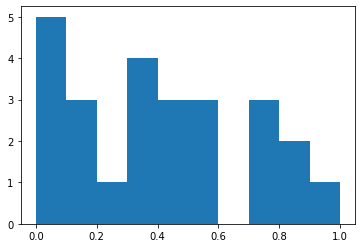

In [20]:
plt.hist(pd.DataFrame(vec_minority_sim_dict)["sim_score"])

In [21]:
figure(figsize=(25, 10), dpi=1200)
sorted_index = np.argsort(vec_minority_sim_dict["sim_score"])

x_axis = np.arange(len(vec_minority_sim_dict["words"]))
y_axis = [vec_minority_sim_dict["sim_score"][i] for i in sorted_index]
x_ticks = [vec_minority_sim_dict["words"][i] for i in sorted_index]
plt.bar(x_axis, y_axis)
plt.xticks(x_axis, x_ticks, fontsize=40, rotation=90, fontweight='bold')
plt.ylabel("similarity score",fontsize=40, fontweight='bold')
plt.yticks(np.arange(0.1,1.1,0.1),fontsize=40, fontweight='bold')
plt.savefig(results_folder+"similarity_score_of_minority_words_to_profanity_vector.pdf", bbox_inches='tight')